# LM_syneval
Use the syntactic pairs from [Marvin and Linzen, 2018](https://github.com/BeckyMarvin/LM_syneval). Compare their diff vector results to the Time Vector results.  
- Compare the magnitude of variance using sns.distplot  
- Compare the orthogonality using cosine similarity  

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import os, sys, time
import pandas as pd
import pickle
import scipy
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import spacy
import torch

from utils import timed_func

In [2]:
import transformers
from transformers import BertModel, BertTokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased', output_hidden_states=False)
nlp = spacy.load("en_core_web_md")

def evaluate_contextual_diff(pair):
    source, target = pair[0], pair[1]
    src_ids = torch.tensor(bert_tokenizer.encode(source)).unsqueeze(0)
    src_vec = bert_model(src_ids)[0].mean(dim=1)[0]  # (768,) torch.tensor
    
    tgt_ids = torch.tensor(bert_tokenizer.encode(target)).unsqueeze(0)
    tgt_vec = bert_model(tgt_ids)[0].mean(dim=1)[0]
    
    d_emb = len(src_vec)  # 768
    diff = src_vec - tgt_vec
    return diff  # 768-dimensional torch.tensor

## Preprocess syneval pairs
For each syneval_task, there are >=2 keys, each pertaning to a category. A category contains list of N sentences, but only the first sentence is syntactically correct.

In [3]:
lm_syneval_dir = "../data/LM_syneval/data"

def get_syneval_data():
    syneval_names = [
        "vp_coord", "subj_rel", "simple_reflexives", 
        "simple_npi_inanim", "simple_npi_anim",
        "simple_agrmt", "sent_comp", "reflexives_across",
        "reflexive_sent_comp", "prep_inanim", "prep_anim",
        "obj_rel_within_inanim", "obj_rel_within_anim",
        "obj_rel_no_comp_within_inanim", "obj_rel_no_comp_within_anim",
        "obj_rel_no_comp_across_inanim", "obj_rel_no_comp_across_anim",
        "obj_rel_across_inanim", "obj_rel_across_anim",
        "npi_across_inanim", "npi_across_anim",
        "long_vp_coord"
    ]

    syneval_data = {}
    eda_data = {
        "name_": [], "keys_": [], "n_item": [], "sample_k0": [], "sample_k1": []
    }
    for name in syneval_names:
        with open(os.path.join(lm_syneval_dir, "templates/{}.pickle".format(name)), "rb") as f:
            data = pickle.load(f)
            syneval_data[name] = data
            
            eda_data["name_"].append(name)
            
            keys = list(data.keys())
            eda_data["keys_"].append(keys)

            n_item = None
            for k in data.keys():
                if n_item is None:
                    n_item = len(data[k])
                else:
                    if len(data[k]) != n_item:
                        n_item = -1  # This means the classes have different nums of items
            eda_data["n_item"].append(n_item)

            eda_data["sample_k0"].append(data[keys[0]][0])
            eda_data["sample_k1"].append(data[keys[1]][0])
    return syneval_data, pd.DataFrame(eda_data)

syneval_data, eda_data = get_syneval_data()
eda_data

,name_,keys_,n_item,sample_k0,sample_k1
0,vp_coord,"[sing_MS_MV_MV, plur_MS_MV_MV]",420,"(the author laughs and swims, the author laugh...","(the authors laugh and swim, the authors laugh..."
1,subj_rel,"[sing_MS_EV_MV_sing_ES, sing_MS_EV_MV_plur_ES,...",2800,"(the author that likes the guard laughs, the a...","(the author that likes the guards laughs, the ..."
2,simple_reflexives,"[sing_MS_ANPHR, plur_MS_ANPHR]",140,"(the author hurt himself, the author hurt them...","(the authors hurt themselves, the authors hurt..."
3,simple_npi_inanim,"[past, future]",72,"(no movies have ever been seen, the movies hav...","(no movies will ever be seen, the movies will ..."
4,simple_npi_anim,"[past, future]",60,"(no authors have ever been popular, the author...","(no authors will ever be popular, the authors ..."
5,simple_agrmt,"[sing_MS_MV, plur_MS_MV]",70,"(the author laughs, the author laugh)","(the authors laugh, the authors laughs)"
6,sent_comp,"[sing_MS_MV_sing_BS, sing_MS_MV_plur_BS, plur_...",420,"(the mechanic said the author laughs, the mech...","(the mechanics said the author laughs, the mec..."
7,reflexives_across,"[sing_MS_ANPHR_sing_ES_EV, sing_MS_ANPHR_plur_...",5600,"(the author that the guard likes hurt himself,...","(the author that the guards like hurt himself,..."
8,reflexive_sent_comp,"[sing_MS_ANPHR_sing_BS, sing_MS_ANPHR_plur_BS,...",840,"(the mechanic said the author hurt himself, th...","(the mechanics said the author hurt himself, t..."
9,prep_inanim,"[sing_IS_IV_sing_ES, sing_IS_IV_plur_ES, plur_...",1260,"(the movie from the guard is good, the movie f...","(the movie from the guards is good, the movie ..."


In [4]:
for i, row in eda_data.iterrows():
    print ("\n{}, {}, {}, {}".format(i, row.name_, row.keys_, row.n_item))
    print (row["sample_k0"])
    print (row["sample_k1"])


0, vp_coord, ['sing_MS_MV_MV', 'plur_MS_MV_MV'], 420
('the author laughs and swims', 'the author laughs and swim')
('the authors laugh and swim', 'the authors laugh and swims')

1, subj_rel, ['sing_MS_EV_MV_sing_ES', 'sing_MS_EV_MV_plur_ES', 'plur_MS_EV_MV_sing_ES', 'plur_MS_EV_MV_plur_ES'], 2800
('the author that likes the guard laughs', 'the author that likes the guard laugh')
('the author that likes the guards laughs', 'the author that likes the guards laugh')

2, simple_reflexives, ['sing_MS_ANPHR', 'plur_MS_ANPHR'], 140
('the author hurt himself', 'the author hurt themselves')
('the authors hurt themselves', 'the authors hurt himself')

3, simple_npi_inanim, ['past', 'future'], 72
('no movies have ever been seen', 'the movies have ever been seen', 'most movies have ever been seen')
('no movies will ever be seen', 'the movies will ever be seen', 'most movies will ever be seen')

4, simple_npi_anim, ['past', 'future'], 60
('no authors have ever been popular', 'the authors have ever

In [5]:
def preprocess_syneval_data(syneval_data, max_per_category=100):
    correct_sents_data = {}
    for name in syneval_data:
        D = {}
        for key in syneval_data[name]:
            allsents = syneval_data[name][key]
            corr_sents = [item[0] for item in allsents]
            D[key] = corr_sents[:min(len(corr_sents), max_per_category)]
        correct_sents_data[name] = D
    return correct_sents_data

correct_sents_data = preprocess_syneval_data(syneval_data)
del syneval_data

In [6]:
correct_sents_data["npi_across_anim"]["past"][0:10]

['no authors that the guards like have ever been popular',
 'no authors that the guards like have ever been famous',
 'no authors that the guards like have ever had children',
 'no authors that the guards admire have ever been popular',
 'no authors that the guards admire have ever been famous',
 'no authors that the guards admire have ever had children',
 'no authors that the guards hate have ever been popular',
 'no authors that the guards hate have ever been famous',
 'no authors that the guards hate have ever had children',
 'no authors that the guards love have ever been popular']

## Examine the embedding diff vectors

In [10]:
@timed_func
def name2vecs(correct_sents_data, name):
    data = correct_sents_data[name]
    if len(data.keys()) > 2:
        print ("{} contains more than 2 categories. I'm taking only the first two".format(name))
    k1, k2 = list(data.keys())[:2]
    diffs = []
    for s1, s2 in zip(data[k1], data[k2]):
        diffs.append(evaluate_contextual_diff([s1, s2]))
    return torch.stack(diffs)  # (N, 768) tensor

names = ["vp_coord", "subj_rel", "simple_reflexives", "sent_comp", "simple_agrmt", 
            "reflexives_across"]
collections = [name2vecs(correct_sents_data, name) for name in names]

name2vecs done in 14.05 seconds.
subj_rel contains more than 2 categories. I'm taking only the first two
name2vecs done in 25.52 seconds.
name2vecs done in 27.17 seconds.
sent_comp contains more than 2 categories. I'm taking only the first two
name2vecs done in 32.57 seconds.
name2vecs done in 26.65 seconds.
reflexives_across contains more than 2 categories. I'm taking only the first two
name2vecs done in 56.01 seconds.


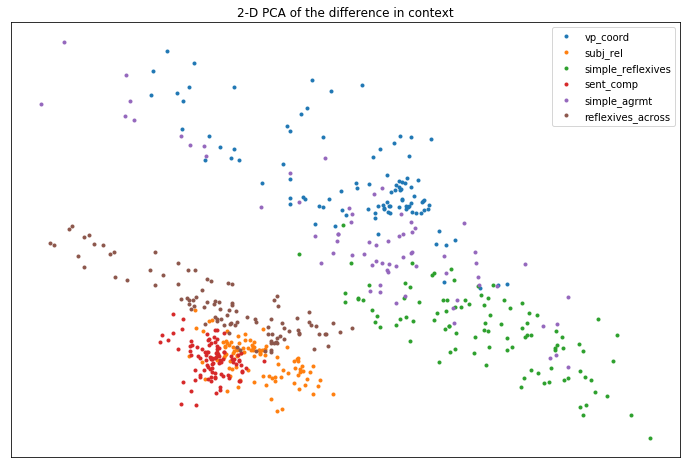

In [11]:
colors = dict(mcolors.TABLEAU_COLORS, **mcolors.CSS4_COLORS)
def make_plot(all_vecs, names):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    
    palette = [
        colors["tab:blue"], colors["tab:orange"], colors["tab:green"], colors["tab:red"], colors["tab:purple"], 
        colors["tab:brown"], colors["tab:pink"], colors["tab:gray"], colors["tab:olive"], colors["tab:cyan"]
    ]
    assert len(palette) >= len(names), "Palette only has {} colors, but requested {}".format(len(palette), len(names))
    
    pca = PCA(n_components=2)
    all_vecs_combined = torch.cat(all_vecs, dim=0)
    pca.fit(all_vecs_combined.detach().numpy())
    for i, vecs in enumerate(all_vecs):
        z = pca.transform(vecs.detach().numpy())  # (n_pt, 2)
        ax.plot(z[:, 0], z[:, 1], "o", c=palette[i], markersize=3, label=names[i])
        
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.legend()
    plt.title('2-D PCA of the difference in context')
    plt.show()

make_plot(collections, names)

## Interpretation?
1. BERT is indeed some sort of "LM as inherent disentangled multitask encoder".  
2. Looks like "subj_rel", "sent_comp" and "reflexives_across" form a large cluster. These three groups happen to be those with >=3 keys (which I take only the first two). The remaining three categories contain only 2 keys.  
3. Marvin & Linzen sentence pairs do not have enough diversity. Probably look at BLiMP data in the next notebook.